# Preliminary operations

In [76]:
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Rectangle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

Download dataset from here: https://github.com/ravi72munde/scala-spark-cab-rides-predictions

# Data Cleaning

In [77]:
df = pd.read_csv("rideshare_kaggle.csv")

In [78]:
df.columns

Index(['id', 'timestamp', 'hour', 'day', 'month', 'datetime', 'timezone',
       'source', 'destination', 'cab_type', 'product_id', 'name', 'price',
       'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperat

In [79]:
df.drop(df.columns[17:], axis = 1, inplace = True)
df.drop('day', axis=1, inplace = True)
df.drop('month', axis=1, inplace = True)
df.drop('product_id', axis=1, inplace = True)
df.drop('timezone', axis=1, inplace = True)

In [80]:
df.head()

,id,timestamp,hour,datetime,source,destination,cab_type,name,price,distance,surge_multiplier,latitude,longitude
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,2018-12-16 09:30:07,Haymarket Square,North Station,Lyft,Shared,5.0,0.44,1.0,42.2148,-71.033
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,2018-11-27 02:00:23,Haymarket Square,North Station,Lyft,Lux,11.0,0.44,1.0,42.2148,-71.033
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,2018-11-28 01:00:22,Haymarket Square,North Station,Lyft,Lyft,7.0,0.44,1.0,42.2148,-71.033
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,2018-11-30 04:53:02,Haymarket Square,North Station,Lyft,Lux Black XL,26.0,0.44,1.0,42.2148,-71.033
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,2018-11-29 03:49:20,Haymarket Square,North Station,Lyft,Lyft XL,9.0,0.44,1.0,42.2148,-71.033


We see that all cab types are equally represented, but we only care about the basic ones, so we only keep 'Lyft' and 'UberX'.

In [81]:
df.drop(df[df['name'] == 'Lux'].index, inplace = True)
df.drop(df[df['name'] == 'Lux Black'].index, inplace = True)
df.drop(df[df['name'] == 'Lux Black XL'].index, inplace = True)
df.drop(df[df['name'] == 'Lyft XL'].index, inplace = True)
df.drop(df[df['name'] == 'Shared'].index, inplace = True)

df.drop(df[df['name'] == 'WAV'].index, inplace = True)
df.drop(df[df['name'] == 'Black SUV'].index, inplace = True)
df.drop(df[df['name'] == 'Black'].index, inplace = True)
df.drop(df[df['name'] == 'UberPool'].index, inplace = True)
df.drop(df[df['name'] == 'UberXL'].index, inplace = True)
df.drop(df[df['name'] == 'Taxi'].index, inplace = True)

# Data Exploration

In [82]:
df['surge_multiplier'].unique()

array([1.  , 1.25, 2.5 , 1.75, 1.5 , 2.  , 3.  ])

In [83]:
data = df[df['name'] == 'Lyft'][['price', 'distance', 'surge_multiplier']]
data = pd.concat([data['price'], data['distance'], data['surge_multiplier']], axis=1)

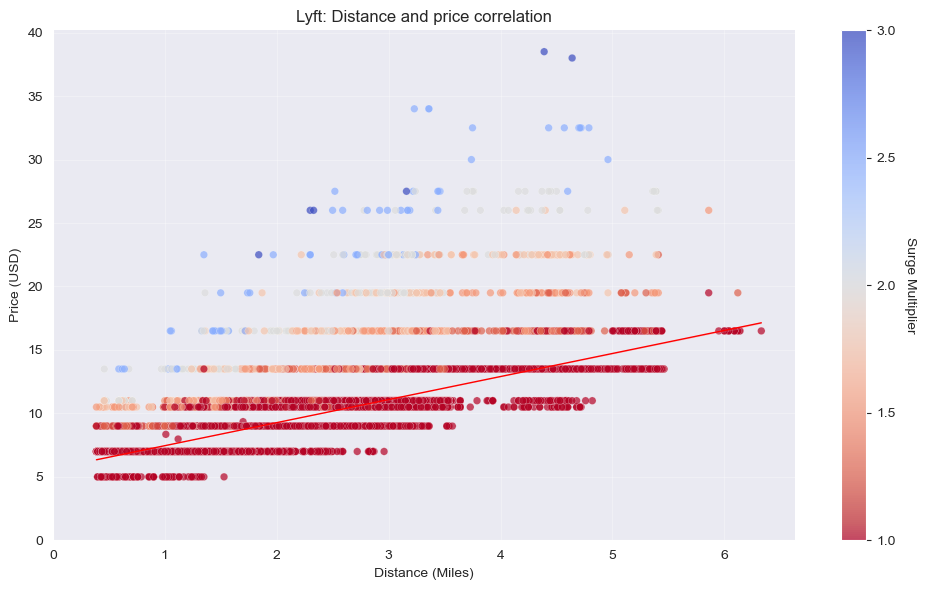

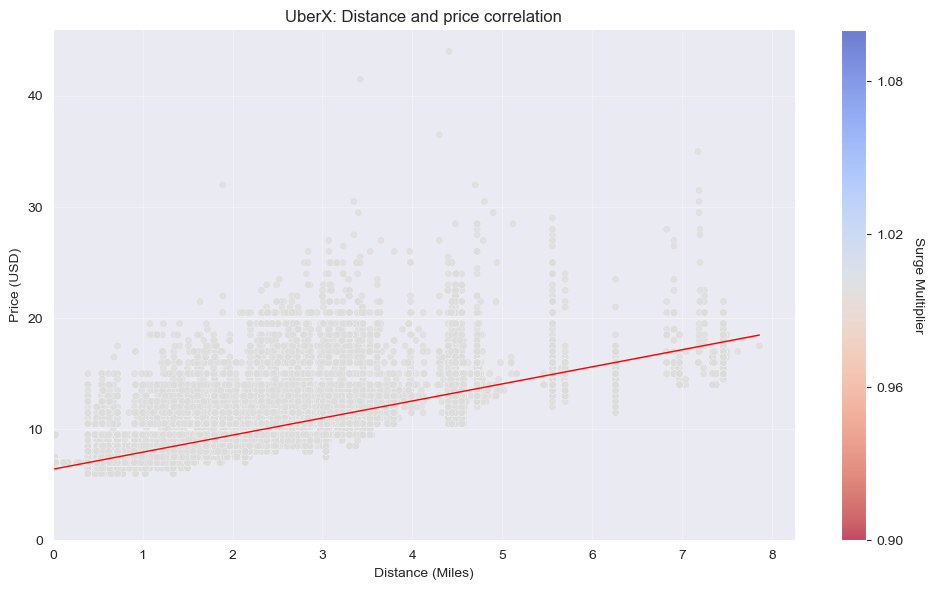

In [84]:
product_id = df['name'].unique()

for product in product_id:
    data = df[df['name'] == product][['price', 'distance', 'surge_multiplier']]
    data = pd.concat([data['price'], data['distance'], data['surge_multiplier']], axis=1)
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.set_title(f'{product}: Distance and price correlation')
    sc = ax.scatter(x='distance', y='price', s=30, c=data['surge_multiplier'], cmap='coolwarm_r', alpha=0.7, edgecolors='w', linewidths=0.2, data=data)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.locator = MaxNLocator(nbins=4)
    cbar.formatter.set_useOffset(False)
    cbar.update_ticks()
    cbar.set_label('Surge Multiplier', rotation=270, labelpad=15)
    ax.grid(True, linestyle='-', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    sns.regplot(x='distance', y='price', color='red', line_kws={'linewidth': 1}, data=data, scatter=False, ax=ax)
    ax.set_xlabel('Distance (Miles)')
    ax.set_ylabel('Price (USD)')
    ax.set_ylim(0)
    ax.set_xlim(0)
    plt.tight_layout()
    plt.show()

We can see that there is a lot less variety with the surge_multiplier for Uber than there is for Lyft.

In [85]:
lyft_df = df.drop(df[df['cab_type'] == 'Uber'].index)
uber_df = df.drop(df[df['cab_type'] == 'Lyft'].index)

# Lyft Price Prediction

### Linear Regression

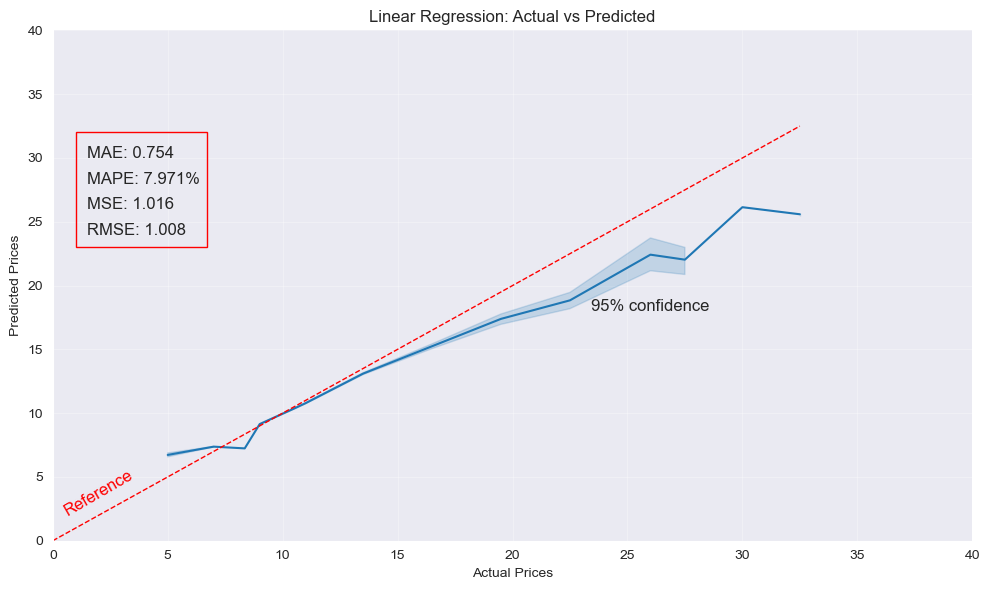

Mean Absolute Error (MAE): 0.754
Mean Squared Error (MSE): 1.016
Root Mean Squared Error (RMSE): 1.008%
MAPE: 7.971%
Accuracy: 92.03


In [91]:
# Features used: 'distance' and 'surge_multiplier'
X = lyft_df[['distance', 'surge_multiplier']]
y = lyft_df['price']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2)

# Train linear regression
regr = linear_model.LinearRegression().fit(X_train, y_train)
# Predict
preds = regr.predict(X_test)

fig, ax = plt.subplots(figsize = (10, 6))
sns.lineplot(x=y_test, y=preds)
plt.title('Linear Regression: Actual vs Predicted')
ax.grid(True, linestyle='-', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.annotate('Reference', (2, 2), textcoords="offset points", xytext=(0,0), ha='center', fontsize=12, color='red', rotation = 30)
ax.annotate('95% confidence', (26, 18), textcoords="offset points", xytext=(0,0), ha='center', fontsize=12)
ax.annotate(f'MAE: {mean_absolute_error(y_test, preds):.3f}', (1.5, 30), textcoords="offset points", xytext=(0,0), ha='left', fontsize=12)
ax.annotate(f'MAPE: {np.mean(np.abs((y_test - preds) / y_test)) * 100:.3f}%', (1.5, 28), textcoords="offset points", xytext=(0,0), ha='left', fontsize=12)
ax.annotate(f'MSE: {mean_squared_error(y_test, preds):.3f}', (1.5, 26), textcoords="offset points", xytext=(0,0), ha='left', fontsize=12)
ax.annotate(f'RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.3f}', (1.5, 24), textcoords="offset points", xytext=(0,0), ha='left', fontsize=12)
ax.set_ylim(0, 40)
ax.set_xlim(0, 40)
rect = Rectangle((1, 23), 5.7, 9, linewidth=1, edgecolor='red', facecolor='none')
ax.add_patch(rect)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', linewidth=1) 
plt.tight_layout()
plt.show()

print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, preds):.3f}')
print(f'Mean Squared Error (MSE): {mean_squared_error(y_test, preds):.3f}')
print(f'Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, preds)):.3f}%')
mape = np.mean(np.abs((y_test - preds) / y_test)) * 100
print(f'MAPE: {mape:.3f}%')
print(f'Accuracy: {(1 - np.mean(np.abs((y_test - preds) / np.abs(y_test)))) * 100:.2f}')

### Random Forest

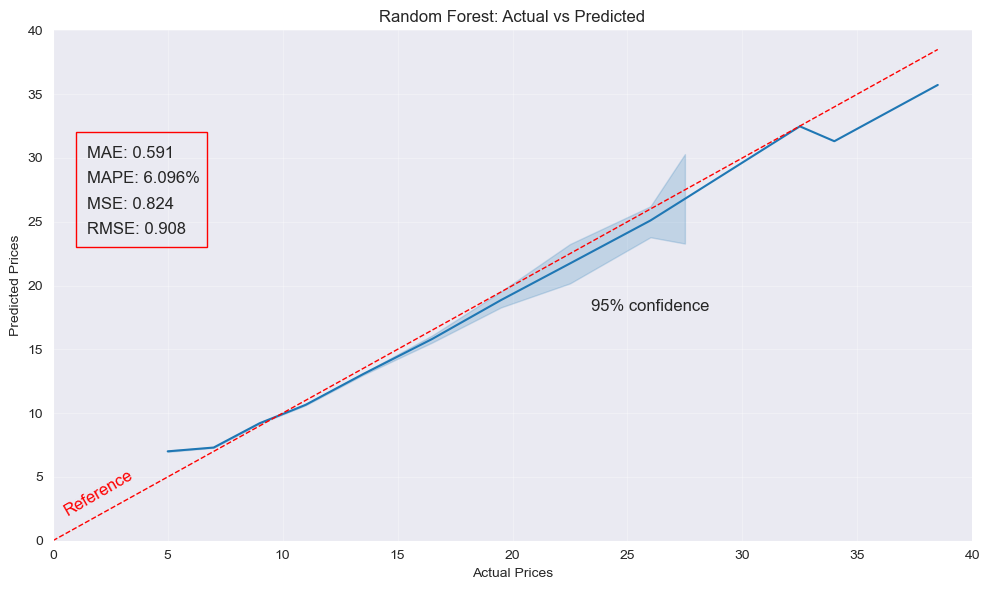

Mean Absolute Error (MAE): 0.591
Mean Squared Error (MSE): 0.824
Root Mean Squared Error (RMSE): 0.908
MAPE: 6.096%
Accuracy: 93.90


In [87]:
# Features used: 'distance' and 'surge_multiplier'
X = lyft_df[['distance', 'surge_multiplier']]
y = lyft_df['price']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2)

# Train random forest
rfc = RandomForestRegressor(max_depth=200)
rfc.fit(X_train, y_train)

# Predict
preds = rfc.predict(X_test)

fig, ax = plt.subplots(figsize = (10, 6))
sns.lineplot(x=y_test, y=preds)
plt.title('Random Forest: Actual vs Predicted')
ax.grid(True, linestyle='-', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.annotate('Reference', (2, 2), textcoords="offset points", xytext=(0,0), ha='center', fontsize=12, color='red', rotation = 30)
ax.annotate('95% confidence', (26, 18), textcoords="offset points", xytext=(0,0), ha='center', fontsize=12)
ax.annotate(f'MAE: {mean_absolute_error(y_test, preds):.3f}', (1.5, 30), textcoords="offset points", xytext=(0,0), ha='left', fontsize=12)
ax.annotate(f'MAPE: {np.mean(np.abs((y_test - preds) / y_test)) * 100:.3f}%', (1.5, 28), textcoords="offset points", xytext=(0,0), ha='left', fontsize=12)
ax.annotate(f'MSE: {mean_squared_error(y_test, preds):.3f}', (1.5, 26), textcoords="offset points", xytext=(0,0), ha='left', fontsize=12)
ax.annotate(f'RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.3f}', (1.5, 24), textcoords="offset points", xytext=(0,0), ha='left', fontsize=12)
ax.set_ylim(0, 40)
ax.set_xlim(0, 40)
rect = Rectangle((1, 23), 5.7, 9, linewidth=1, edgecolor='red', facecolor='none')
ax.add_patch(rect)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', linewidth=1) 
plt.tight_layout()
plt.show()
         
print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, preds):.3f}')
print(f'Mean Squared Error (MSE): {mean_squared_error(y_test, preds):.3f}')
print(f'Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, preds)):.3f}')
mape = np.mean(np.abs((y_test - preds) / y_test)) * 100
print(f'MAPE: {mape:.3f}%')
print(f'Accuracy: {(1 - np.mean(np.abs((y_test - preds) / np.abs(y_test)))) * 100:.2f}')

From the test accuracy of the model we can see that it is able to predict correctly the price of a ride.

In [88]:
rfc = RandomForestRegressor(max_depth=200)
rfc.fit(X.values, y.values)

RandomForestRegressor(max_depth=200)

In [89]:
filename = 'lyft_model.pkl'
pickle.dump(rfc, open(filename, 'wb'))